In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

In [2]:
all_results = pd.read_csv('results/experiment_results.csv')

In [3]:
measurements = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'average_precision',
               'collecting_datasets', 'training', 'training_per_epoch', 'prediction']
    
measurements_aggregation = { m: ['mean', 'std'] for m in measurements }

measurement_names = { m: m.capitalize().replace('_', ' ') for m in measurements }
for m in ['collecting_datasets', 'training', 'training_per_epoch', 'prediction']:
    measurement_names[m] += ' time [s]'

In [4]:
train_size_results = all_results[all_results['experiment_type'] == 'train size']
grouped_train_size = train_size_results.groupby('train_size').agg(measurements_aggregation)
grouped_train_size

accuracy           precision              recall            \
                mean       std      mean       std      mean       std   
train_size                                                               
50.0        0.875102  0.027918  0.111343  0.153980  0.119339  0.164631   
100.0       0.895698  0.001355  0.114483  0.255991  0.022222  0.049690   
500.0       0.894744  0.004224  0.511727  0.107474  0.076229  0.048078   
1000.0      0.896428  0.001895  0.596797  0.081374  0.088242  0.075186   
5000.0      0.902461  0.001679  0.599598  0.038595  0.220161  0.024990   
10000.0     0.902938  0.001749  0.631209  0.052978  0.187528  0.017665   

            f1_score             roc_auc           average_precision  \
                mean       std      mean       std              mean   
train_size                                                             
50.0        0.115196  0.159113  0.648981  0.054400          0.215845   
100.0       0.037220  0.083226  0.696416  0.056207          0.255646   
500.0       0.127137  0.071332  0.703868  0.040472          0.260774   
1000.0      0.140258  0.111140  0.753765  0.011462          0.332827   
5000.0      0.320576  0.021429  0.821087  0.009567          0.420539   
10000.0     0.287916  0.016747  0.832583  0.006706          0.436582   

                     collecting_datasets              training              \
                 std                mean       std        mean         std   
train_size                                                                   
50.0        0.048313            0.010071  0.000274   10.990044   11.188756   
100.0       0.053043            0.010070  0.000181    7.086808    2.344470   
500.0       0.042239            0.011286  0.002620   20.518525    4.654742   
1000.0      0.018224            0.010170  0.000128   50.700990   21.426048   
5000.0      0.008711            0.010119  0.000059  359.618473   89.084126   
10000.0     0.012255            0.010242  0.000254  684.590875  106.655411   

           training_per_epoch           prediction            
                         mean       std       mean       std  
train_size                                                    
50.0                 0.206940  0.010598   8.649682  0.024051  
100.0                0.230073  0.002598   8.645141  0.023027  
500.0                0.569684  0.004327   8.546120  0.088140  
1000.0               0.966761  0.004436   8.616580  0.048345  
5000.0               4.540534  0.009249   8.617423  0.165618  
10000.0              8.960866  0.019269   8.807485  0.252827

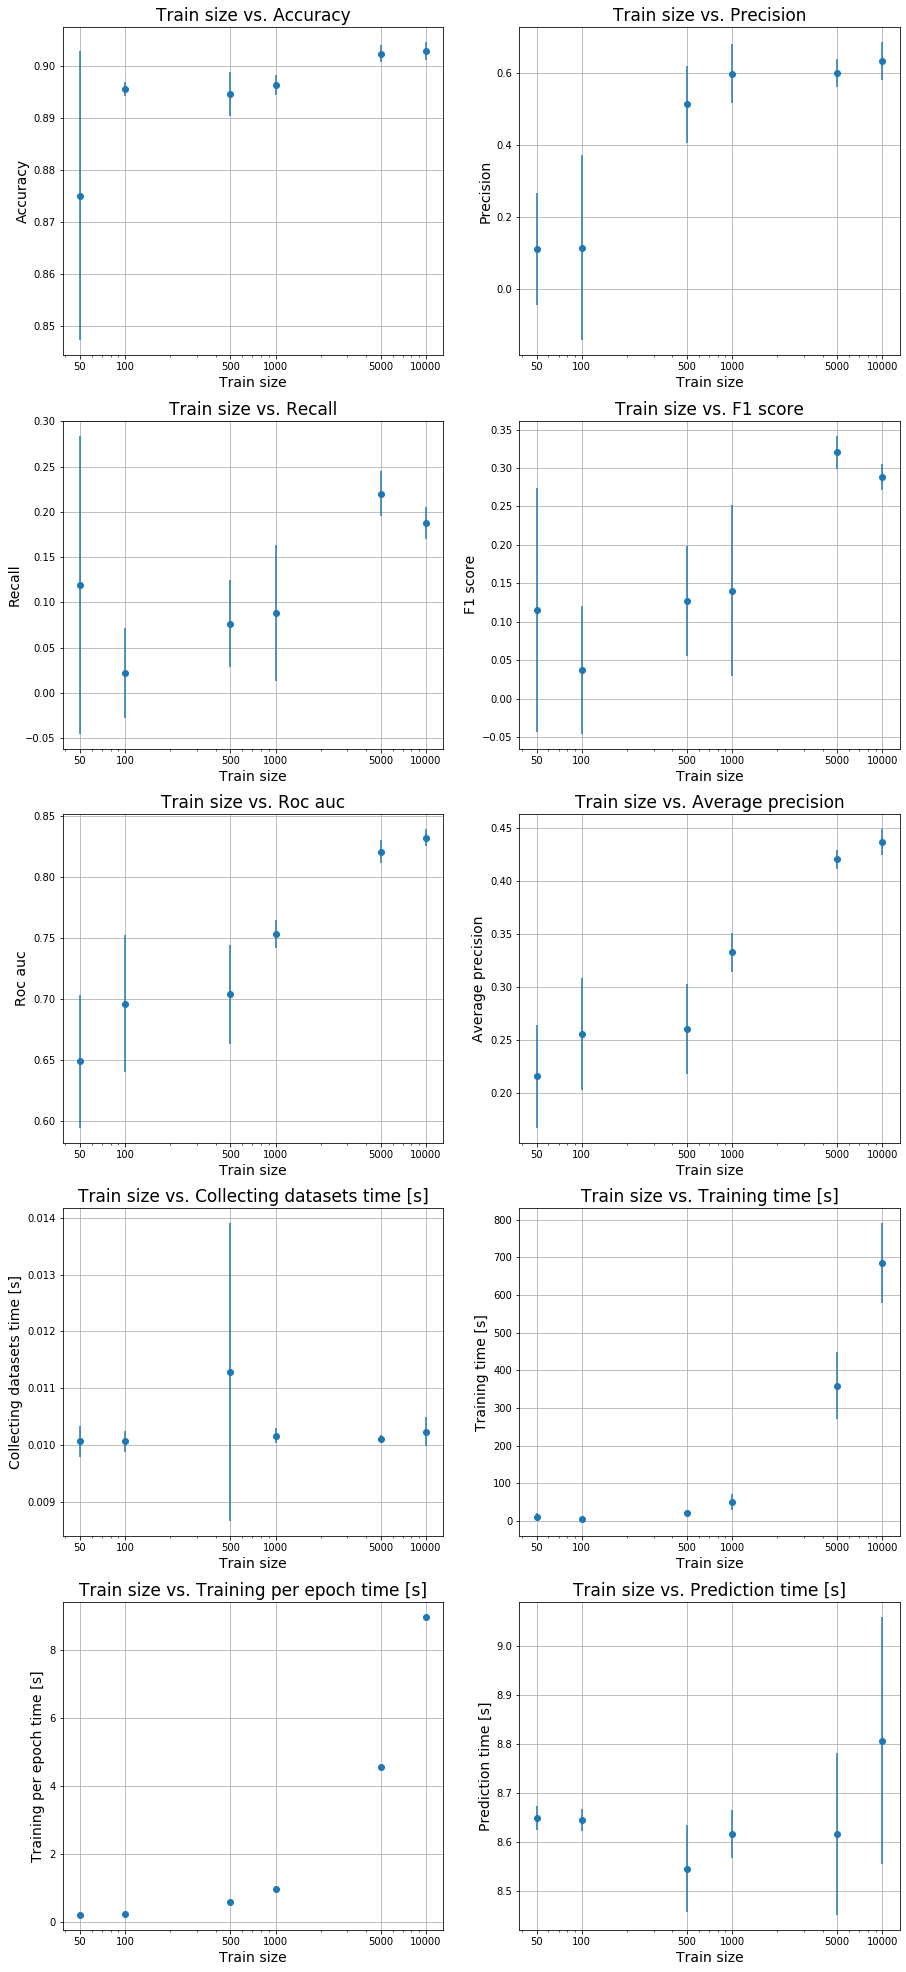

In [5]:
fig, axes = plt.subplots(nrows=len(measurements)// 2, ncols=2, figsize=(15, 3.5 * len(measurements)))
for i, m in enumerate(measurements):
    ax = axes[i // 2][i % 2]
    ax.errorbar(
        grouped_train_size.index,
        grouped_train_size[m]['mean'], grouped_train_size[m]['std'],
        linestyle='None', marker='o'
    )
    ax.set_xscale('log')
    ax.set_xticks(grouped_train_size.index)
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    ax.set_xlabel('Train size', size=14)
    ax.set_ylabel(measurement_names[m], size=14)
    ax.set_title(f'Train size vs. {measurement_names[m]}', size=17)
    ax.grid(True)
plt.show()

In [6]:
workers_results = all_results[all_results['experiment_type'] == 'num of workers']
grouped_workers = workers_results.groupby('num_of_workers').agg(measurements_aggregation)
grouped_workers

accuracy           precision              recall            \
                    mean       std      mean       std      mean       std   
num_of_workers                                                               
1               0.905913  0.001618  0.643503  0.034257  0.235148  0.021566   
2               0.905576  0.001821  0.632838  0.032804  0.241034  0.017457   
4               0.905071  0.002359  0.621435  0.039370  0.249329  0.021987   
8               0.906109  0.001269  0.641624  0.032672  0.242102  0.021063   

                f1_score             roc_auc           average_precision  \
                    mean       std      mean       std              mean   
num_of_workers                                                             
1               0.343457  0.018949  0.853097  0.004427          0.471157   
2               0.348449  0.015964  0.852453  0.004679          0.470145   
4               0.354788  0.017709  0.853070  0.004635          0.469923   
8               0.350539  0.017437  0.853904  0.003995          0.472123   

                         collecting_datasets               training  \
                     std                mean       std         mean   
num_of_workers                                                        
1               0.009673            0.004566  0.000257  1851.433588   
2               0.009761            0.007814  0.000182  1874.410289   
4               0.011874            0.013429  0.000367  1872.917048   
8               0.008533            0.027148  0.000484  1828.953821   

                           training_per_epoch           prediction            
                       std               mean       std       mean       std  
num_of_workers                                                                
1               180.672720          25.568164  0.067774   8.941290  0.657966  
2               168.295312          25.959416  0.125072   8.995412  0.633908  
4               165.923201          26.145987  0.196387   9.037754  0.604287  
8               219.519413          26.272398  0.091085   9.063437  0.651384

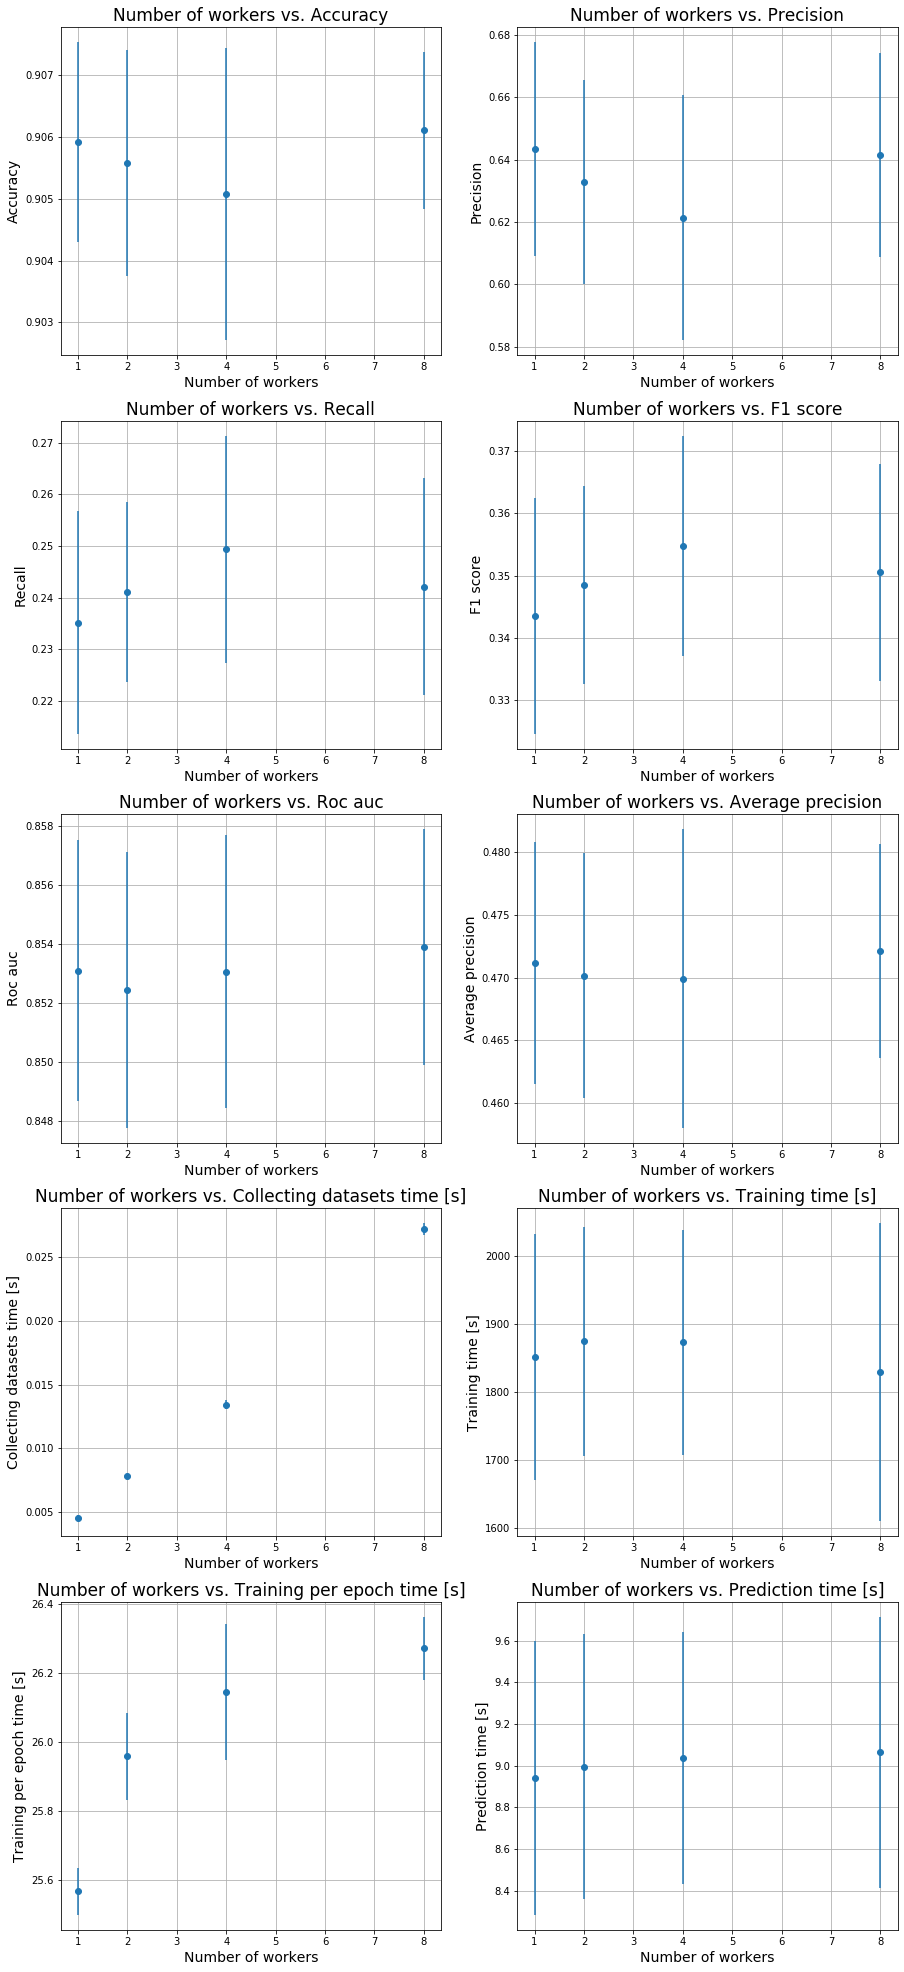

In [7]:
fig, axes = plt.subplots(nrows=len(measurements)// 2, ncols=2, figsize=(15, 3.5 * len(measurements)))
for i, m in enumerate(measurements):
    ax = axes[i // 2][i % 2]
    ax.errorbar(
        grouped_workers.index,
        grouped_workers[m]['mean'], grouped_workers[m]['std'],
        linestyle='None', marker='o'
    )
    #ax.set_xscale('log')
    #ax.set_xticks(grouped_workers.index)
    #ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    ax.set_xlabel('Number of workers', size=14)
    ax.set_ylabel(measurement_names[m], size=14)
    ax.set_title(f'Number of workers vs. {measurement_names[m]}', size=17)
    ax.grid(True)
plt.show()